### OT Couplings via `linear_sum_assignment`

In [3]:
import torch
import torch.nn as nn
import nami

import matplotlib.pyplot as plt

def make_spiral(n_points, noise=0.01):
    theta = torch.linspace(0, 4 * torch.pi, n_points)
    r = theta
    x = r * torch.cos(theta) + noise * torch.randn(n_points)
    y = r * torch.sin(theta) + noise * torch.randn(n_points)
    return torch.stack([x, y], dim=1)

all_data1 = [make_spiral(n, noise=0.01) for n in (64, 128, 256)]

In [4]:
import time
from scipy.optimize import linear_sum_assignment

def ot_pair(x_source, x_target):
    cost = torch.cdist(x_source, x_target)
    _, col_idx = linear_sum_assignment(cost.cpu().numpy())
    return x_source, x_target[col_idx]


def train_and_sample(data, n_steps=1000, n_samples=256, print_every=100):
    """
    Train and sample
    """
    dim = data.shape[-1]
    n_training_samples = data.shape[0]
    
    field = nami.VelocityField(dim)
    optimizer = torch.optim.Adam(field.parameters(), lr=1e-3)
    
    losses = []
    t0 = time.perf_counter()
    for step in range(n_steps):
        x_source = torch.randn_like(data)
        x_source, x_target = ot_pair(x_source, data)
        
        loss = nami.fm_loss(field, x_target, x_source)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if (step + 1) % print_every == 0 or step == 0 or step == n_steps - 1:
            print(f"Dataset size: {n_training_samples:4d} | "
                  f"Step: {step + 1:4d}/{n_steps} | "
                  f"Loss: {loss:.6f} | "
                  f"Batch size: {n_training_samples} (full dataset)")
    
    train_time = time.perf_counter() - t0
    print(f"\nTraining complete! Dataset: {n_training_samples} samples, "
          f"Final loss: {losses[-1]:.6f}\n")
    
    base = nami.StandardNormal(event_shape=(dim,))
    solver = nami.RK4(steps=64)
    fm = nami.FlowMatching(field, base, solver, event_ndim=1)
    
    t0 = time.perf_counter()
    samples = fm(None).sample((n_samples,)).detach()
    sample_time = time.perf_counter() - t0
    print(f"Generated {n_samples} samples | Sample time: {sample_time:.3f}s")
    
    return {
        "losses": losses,
        "samples": samples,
        "train_time": train_time,
        "sample_time": sample_time,
        "final_loss": losses[-1],
        "fm": fm,
        "field": field,
        "dataset_size": n_training_samples,
        "batch_size": n_training_samples,
    }



results = {}

for i, item in enumerate(all_data1):
    if isinstance(item, (list, tuple)) and len(item) == 2:
        n, data = item
    else:
        n = i
        data = item
    results[n] = train_and_sample(data, n_steps=400, print_every=100)

Dataset size:   64 | Step:    1/400 | Loss: 20.275225 | Batch size: 64 (full dataset)
Dataset size:   64 | Step:  100/400 | Loss: 2.457340 | Batch size: 64 (full dataset)
Dataset size:   64 | Step:  200/400 | Loss: 1.635045 | Batch size: 64 (full dataset)
Dataset size:   64 | Step:  300/400 | Loss: 1.342945 | Batch size: 64 (full dataset)
Dataset size:   64 | Step:  400/400 | Loss: 1.875089 | Batch size: 64 (full dataset)

Training complete! Dataset: 64 samples, Final loss: 1.875089

Generated 256 samples | Sample time: 0.181s
Dataset size:  128 | Step:    1/400 | Loss: 19.216558 | Batch size: 128 (full dataset)
Dataset size:  128 | Step:  100/400 | Loss: 2.287911 | Batch size: 128 (full dataset)
Dataset size:  128 | Step:  200/400 | Loss: 1.352042 | Batch size: 128 (full dataset)
Dataset size:  128 | Step:  300/400 | Loss: 1.590656 | Batch size: 128 (full dataset)
Dataset size:  128 | Step:  400/400 | Loss: 1.386060 | Batch size: 128 (full dataset)

Training complete! Dataset: 128 sam

In [5]:
print("n_data,train_time,sample_time,final_loss")
for n, r in results.items():
    print(f"{n},{r['train_time']:.4f},{r['sample_time']:.4f},{r['final_loss']:.6f}")

n_data,train_time,sample_time,final_loss
0,0.8035,0.1814,1.875089
1,1.4867,0.1676,1.386060
2,4.3068,0.1410,1.020206


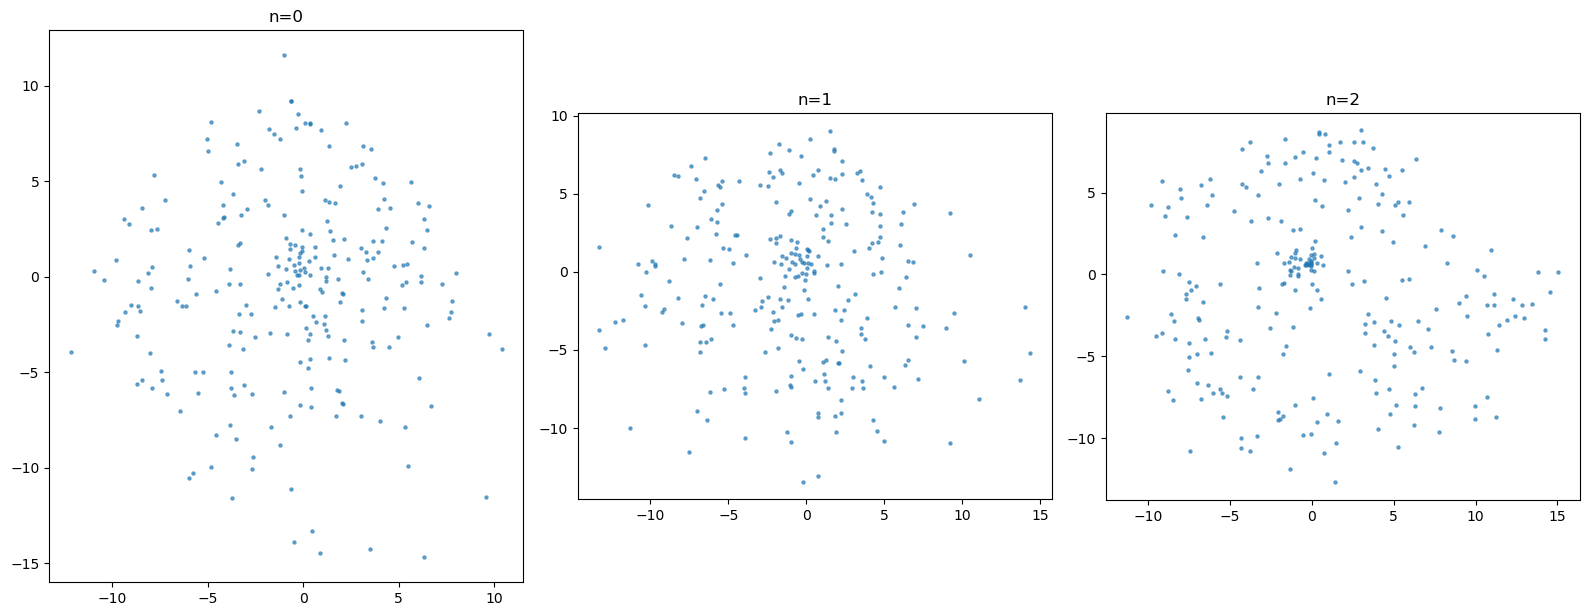

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(16, 8))
for ax, (n, r) in zip(axes.flat, results.items()):
    s = r["samples"].numpy()
    ax.scatter(s[:, 0], s[:, 1], s=5, alpha=0.6)
    ax.set_title(f"n={n}")
    ax.set_aspect("equal")
plt.tight_layout()
plt.show()

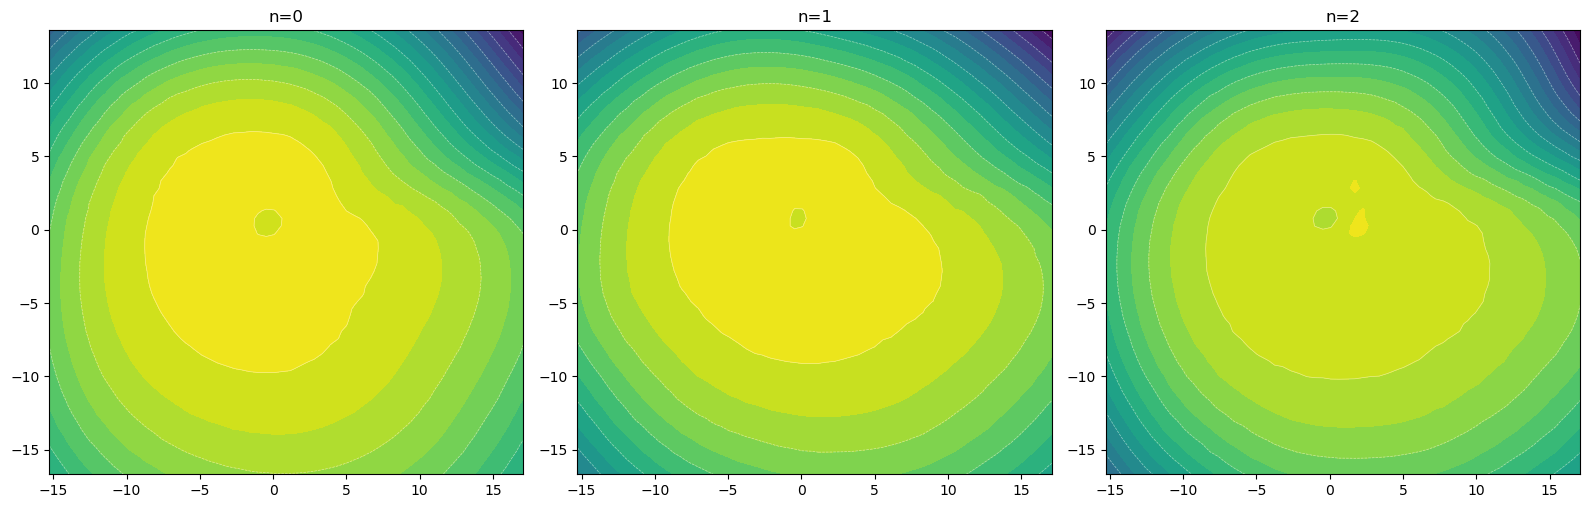

In [7]:
# plot the likelihood contours
import numpy as np
def compute_log_prob_grid(fm, xlim, ylim, resolution=50):
    x = torch.linspace(*xlim, resolution)
    y = torch.linspace(*ylim, resolution)
    xx, yy = torch.meshgrid(x, y, indexing="xy")
    grid = torch.stack([xx.flatten(), yy.flatten()], dim=-1)
    
    estimator = nami.HutchinsonDivergence()
    #estimator = nami.ExactDivergence()
    with torch.no_grad():
        logp = fm(None).log_prob(grid, estimator=estimator)
    return xx.numpy(), yy.numpy(), logp.reshape(resolution, resolution).numpy()

# compute grid bounds from all samples
all_samples = torch.cat([r["samples"] for r in results.values()])
margin = 2
xlim = (all_samples[:, 0].min().item() - margin, all_samples[:, 0].max().item() + margin)
ylim = (all_samples[:, 1].min().item() - margin, all_samples[:, 1].max().item() + margin)

fig, axes = plt.subplots(1, 3, figsize=(16, 8))
for ax, (n, r) in zip(axes.flat, results.items()):
    xx, yy, logp = compute_log_prob_grid(r["fm"], xlim, ylim, resolution=60)
    ax.contourf(xx, yy, logp, levels=20, cmap="viridis")
    ax.contour(xx, yy, logp, levels=10, colors="white", linewidths=0.5, alpha=0.5)
    ax.set_title(f"n={n}")
    ax.set_aspect("equal")
plt.tight_layout()
plt.show()